<a href="https://colab.research.google.com/github/danjonesss/ResearchProject/blob/main/Medical_Image_Classifier_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install codecarbon
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.6/174.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 86.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=40672c066e10f26cbf56f0736d284b15e8a0cf6c6720a3713ce2bde725f75961
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [23]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score
from sklearn.datasets import fetch_openml
import seaborn as sns
from codecarbon import EmissionsTracker
import time
from skimage.color import gray2rgb, rgb2gray, label2rgb
from random import randint
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Normalizer
from skimage.segmentation import mark_boundaries
from sklearn.model_selection import train_test_split
import cv2
from sklearn import svm
from google.colab import drive
import os
from PIL import Image
from keras.callbacks import EarlyStopping, ModelCheckpoint
from lime import lime_image
from keras.regularizers import l2

In [13]:
def load_images_from_folder(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        with Image.open(img_path).convert('RGB') as img:
            images.append(np.array(img))
            label = 1 if folder == yes_path else 0
            labels.append(label)
    return images, labels

# Paths to your dataset folders on Google Drive
yes_path = '/content/drive/My Drive/tumor_dataset/demented'
no_path = '/content/drive/My Drive/tumor_dataset/non_demented'

# Loading images and labels from both folders
x_data = []
y_data = []
for folder in [yes_path, no_path]:
    folder_images, folder_labels = load_images_from_folder(folder)
    x_data.extend(folder_images)
    y_data.extend(folder_labels)

x_data = np.array(x_data)
y_data = np.array(y_data)

num_classes = 2



In [31]:
# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                    y_data,
                                                    test_size=0.2,
                                                    random_state=42)

early_stopping = EarlyStopping(monitor='val_loss',
                              patience=5,
                              verbose=1,
                              restore_best_weights=True)

ET = EmissionsTracker()
ET.start()
input_shape = (128,128,3)

x_train = x_train.astype("float32")/255
x_test = x_test.astype("float32")/255

print("x_train shape:", x_train.shape)
print(x_train.shape[0],"train samples")
print(x_test.shape[0],"test samples")

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),

        layers.Conv2D(32, kernel_size=(3, 3), activation="elu", padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(64, kernel_size=(3, 3), activation="elu", padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(128, kernel_size=(3, 3), activation="elu", padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(128, kernel_size=(3, 3), activation="elu", padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Flatten(),
        layers.Dense(64, activation="elu", kernel_regularizer=l2(0.01)),
        layers.Dropout(0.5),

        layers.Dense(32, activation="elu", kernel_regularizer=l2(0.01)),
        layers.Dropout(0.5),

        layers.Dense(1, activation="sigmoid"),
    ]
)

model.summary()
batch_size = 32
epochs = 32

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

StartTime = time.time()
history=model.fit(x_train,
                  y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_split=0.1,
                  verbose=1,
                  callbacks=[early_stopping])
emissions: float = ET.stop()
EndTime = time.time() - StartTime

[codecarbon INFO @ 15:04:46] [setup] RAM Tracking...
[codecarbon INFO @ 15:04:46] [setup] GPU Tracking...
[codecarbon INFO @ 15:04:46] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 15:04:46] [setup] CPU Tracking...
[codecarbon WARNING @ 15:04:46] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 15:04:47] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 15:04:47] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 15:04:47] >>> Tracker's metadata:
[codecarbon INFO @ 15:04:47]   Platform system: Linux-6.1.58+-x86_64-with-glibc2.35
[codecarbon INFO @ 15:04:47]   Python version: 3.10.12
[codecarbon INFO @ 15:04:47]   CodeCarbon version: 2.3.5
[codecarbon INFO @ 15:04:47]   Available RAM : 12.675 GB
[codecarbon INFO @ 15:04:47]   CPU count: 2
[codecarbon INFO @ 15:04:47]   CPU model: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 15:04:47]   GPU c

x_train shape: (5128, 128, 128, 3)
5128 train samples
1282 test samples
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_24 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 32, 32, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 32, 32, 128)       73856     
                                                

[codecarbon INFO @ 15:04:51] Energy consumed for RAM : 0.001624 kWh. RAM Power : 4.753046035766602 W
[codecarbon INFO @ 15:04:51] Energy consumed for all GPUs : 0.016942 kWh. Total GPU Power : 35.71724811806586 W
[codecarbon INFO @ 15:04:51] Energy consumed for all CPUs : 0.014534 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:04:51] 0.033101 kWh of electricity used since the beginning.


Epoch 1/32
145/145 [==============================] - 8s 28ms/step - loss: 1.4583 - accuracy: 0.5801 - val_loss: 0.9451 - val_accuracy: 0.7135
Epoch 2/32
123/145 [========================>.....] - ETA: 0s - loss: 0.8632 - accuracy: 0.6639

[codecarbon INFO @ 15:05:03] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.753046035766602 W
[codecarbon INFO @ 15:05:03] Energy consumed for all GPUs : 0.000212 kWh. Total GPU Power : 50.86291048998667 W
[codecarbon INFO @ 15:05:03] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:05:03] 0.000410 kWh of electricity used since the beginning.


145/145 [==============================] - 4s 25ms/step - loss: 0.8465 - accuracy: 0.6728 - val_loss: 0.7084 - val_accuracy: 0.7700
Epoch 3/32
110/145 [=====================>........] - ETA: 0s - loss: 0.7260 - accuracy: 0.7213

[codecarbon INFO @ 15:05:06] Energy consumed for RAM : 0.001644 kWh. RAM Power : 4.753046035766602 W
[codecarbon INFO @ 15:05:06] Energy consumed for all GPUs : 0.017185 kWh. Total GPU Power : 58.39640094644974 W
[codecarbon INFO @ 15:05:06] Energy consumed for all CPUs : 0.014711 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:05:06] 0.033540 kWh of electricity used since the beginning.


145/145 [==============================] - 4s 24ms/step - loss: 0.7177 - accuracy: 0.7289 - val_loss: 0.6138 - val_accuracy: 0.8187
Epoch 4/32
145/145 [==============================] - 3s 23ms/step - loss: 0.5855 - accuracy: 0.8182 - val_loss: 0.4827 - val_accuracy: 0.8772
Epoch 5/32
145/145 [==============================] - 4s 24ms/step - loss: 0.4619 - accuracy: 0.9107 - val_loss: 0.5754 - val_accuracy: 0.8558
Epoch 6/32
144/145 [============================>.] - ETA: 0s - loss: 0.3158 - accuracy: 0.9635

[codecarbon INFO @ 15:05:18] Energy consumed for RAM : 0.000040 kWh. RAM Power : 4.753046035766602 W
[codecarbon INFO @ 15:05:18] Energy consumed for all GPUs : 0.000501 kWh. Total GPU Power : 69.17121366177744 W
[codecarbon INFO @ 15:05:18] Energy consumed for all CPUs : 0.000355 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:05:18] 0.000895 kWh of electricity used since the beginning.


145/145 [==============================] - 4s 27ms/step - loss: 0.3156 - accuracy: 0.9636 - val_loss: 0.2411 - val_accuracy: 0.9747
Epoch 7/32
142/145 [============================>.] - ETA: 0s - loss: 0.1944 - accuracy: 0.9875

[codecarbon INFO @ 15:05:21] Energy consumed for RAM : 0.001664 kWh. RAM Power : 4.753046035766602 W
[codecarbon INFO @ 15:05:21] Energy consumed for all GPUs : 0.017472 kWh. Total GPU Power : 69.06468179305028 W
[codecarbon INFO @ 15:05:21] Energy consumed for all CPUs : 0.014888 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:05:21] 0.034024 kWh of electricity used since the beginning.


145/145 [==============================] - 3s 24ms/step - loss: 0.1938 - accuracy: 0.9876 - val_loss: 0.1899 - val_accuracy: 0.9766
Epoch 8/32
145/145 [==============================] - 3s 23ms/step - loss: 0.1619 - accuracy: 0.9881 - val_loss: 0.2405 - val_accuracy: 0.9825
Epoch 9/32
145/145 [==============================] - 3s 23ms/step - loss: 0.2545 - accuracy: 0.9770 - val_loss: 0.2107 - val_accuracy: 0.9747
Epoch 10/32
145/145 [==============================] - 4s 26ms/step - loss: 0.1481 - accuracy: 0.9946 - val_loss: 0.1233 - val_accuracy: 0.9864
Epoch 11/32
 40/145 [=======>......................] - ETA: 2s - loss: 0.0950 - accuracy: 0.9984

[codecarbon INFO @ 15:05:33] Energy consumed for RAM : 0.000059 kWh. RAM Power : 4.753046035766602 W
[codecarbon INFO @ 15:05:33] Energy consumed for all GPUs : 0.000790 kWh. Total GPU Power : 69.41568181287644 W
[codecarbon INFO @ 15:05:33] Energy consumed for all CPUs : 0.000532 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:05:33] 0.001381 kWh of electricity used since the beginning.


145/145 [==============================] - 3s 23ms/step - loss: 0.0769 - accuracy: 0.9991 - val_loss: 0.0761 - val_accuracy: 0.9922
Epoch 12/32
 37/145 [======>.......................] - ETA: 2s - loss: 0.0573 - accuracy: 1.0000

[codecarbon INFO @ 15:05:36] Energy consumed for RAM : 0.001684 kWh. RAM Power : 4.753046035766602 W
[codecarbon INFO @ 15:05:36] Energy consumed for all GPUs : 0.017762 kWh. Total GPU Power : 69.58633066313907 W
[codecarbon INFO @ 15:05:36] Energy consumed for all CPUs : 0.015065 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:05:36] 0.034511 kWh of electricity used since the beginning.


145/145 [==============================] - 3s 23ms/step - loss: 0.0674 - accuracy: 0.9985 - val_loss: 0.0840 - val_accuracy: 0.9922
Epoch 13/32
145/145 [==============================] - 3s 24ms/step - loss: 0.4022 - accuracy: 0.9454 - val_loss: 0.6867 - val_accuracy: 0.9649
Epoch 14/32
145/145 [==============================] - 4s 25ms/step - loss: 0.3635 - accuracy: 0.9855 - val_loss: 0.2110 - val_accuracy: 0.9786
Epoch 15/32
 91/145 [=================>............] - ETA: 1s - loss: 0.1238 - accuracy: 0.9990

[codecarbon INFO @ 15:05:48] Energy consumed for RAM : 0.000079 kWh. RAM Power : 4.753046035766602 W
[codecarbon INFO @ 15:05:48] Energy consumed for all GPUs : 0.001078 kWh. Total GPU Power : 69.24930633081823 W
[codecarbon INFO @ 15:05:48] Energy consumed for all CPUs : 0.000709 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:05:48] 0.001866 kWh of electricity used since the beginning.


145/145 [==============================] - 3s 23ms/step - loss: 0.1070 - accuracy: 0.9991 - val_loss: 0.0889 - val_accuracy: 0.9903
Epoch 16/32
 91/145 [=================>............] - ETA: 1s - loss: 0.0551 - accuracy: 0.9997

[codecarbon INFO @ 15:05:51] Energy consumed for RAM : 0.001704 kWh. RAM Power : 4.753046035766602 W
[codecarbon INFO @ 15:05:51] Energy consumed for all GPUs : 0.018050 kWh. Total GPU Power : 69.22851532702566 W
[codecarbon INFO @ 15:05:51] Energy consumed for all CPUs : 0.015242 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:05:51] 0.034996 kWh of electricity used since the beginning.


145/145 [==============================] - 3s 23ms/step - loss: 0.0570 - accuracy: 0.9993 - val_loss: 0.0775 - val_accuracy: 0.9922
Epoch 16: early stopping


[codecarbon INFO @ 15:05:53] Energy consumed for RAM : 0.000085 kWh. RAM Power : 4.753046035766602 W
[codecarbon INFO @ 15:05:53] Energy consumed for all GPUs : 0.001167 kWh. Total GPU Power : 69.15325790596496 W
[codecarbon INFO @ 15:05:53] Energy consumed for all CPUs : 0.000764 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 15:05:53] 0.002017 kWh of electricity used since the beginning.


In [32]:
score = model.evaluate(x_test, y_test, verbose=1)
y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_test,y_pred)
print(cm)
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TP = cm[1][1]

accuracy = ((TP + TN) / (TP + TN + FP + FN))*100
precision = (TP / (TP + FP))*100
recall = (TP / (TP + FN))*100
f1 = (2 * (precision * recall) / (precision + recall))

accuracy = round(accuracy,2)
precision = round(precision,2)
recall = round(recall,2)
f1 = round(f1,2)
print("")
print("Accuracy: ",accuracy,"%")
print("Precision: ",precision,"%")
print("Recall: ",recall,"%")
print("F1 Score: ",f1,"%")

41/41 [==============================] - 0s 8ms/step
[[598   6]
 [  6 672]]

Accuracy:  99.06 %
Precision:  99.12 %
Recall:  99.12 %
F1 Score:  99.12 %


Test loss: 0.08
Test accuracy: 0.99


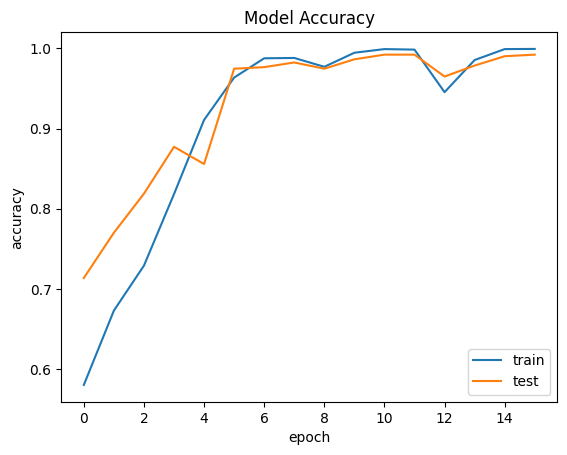


Emissions: 0.0009856597118013317 kg

Time taken:  63.97306251525879 seconds

Accuracy :  99.06 %



In [33]:
print("Test loss:", round(score[0],2))
print("Test accuracy:", round(score[1],2))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
print("")
print(f'Emissions: {emissions} kg')
print("")
print("Time taken: ", EndTime, "seconds")
print("")
print("Accuracy : ", accuracy, "%")
print("")

In [34]:
model.save('99percent.keras')

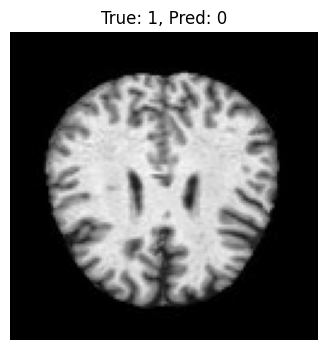

In [7]:
y_pred = y_pred.flatten()
misclassified_indices = np.where(y_test != y_pred)[0]
classified_indices = np.where(y_test == y_pred)[0]
wrong_idx = np.random.choice(misclassified_indices)
right_idx = np.random.choice(classified_indices)
len(misclassified_indices)

def plot_single_misclassified_image(misclassified_indices, x_data, y_true, y_pred):
    # Check if there are any misclassified samples
    if len(misclassified_indices) > 0:
        # Select a random sample of one misclassified index
        idx = np.random.choice(misclassified_indices, 1)[0]

        # Plotting
        plt.figure(figsize=(6, 4))  # Adjust figure size if necessary
        plt.imshow(x_data[idx].reshape(128, 128, 3))  # Display the color image
        title = f'True: {y_true[idx]}, Pred: {y_pred[idx]}'
        plt.title(title, fontsize=12)
        plt.axis('off')
        plt.show()
    else:
        print("No misclassified samples found.")

plot_single_misclassified_image(misclassified_indices, x_test, y_test, y_pred)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


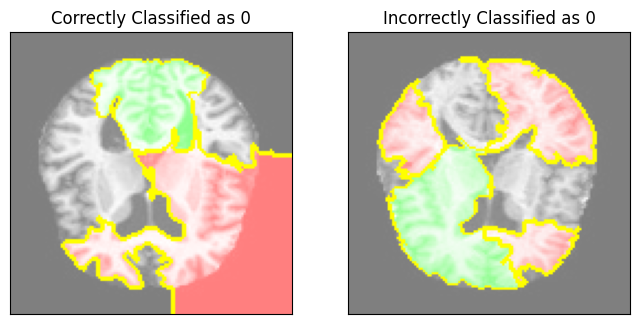

In [8]:
correct = np.random.choice(classified_indices, 1)[0]
incorrect = np.random.choice(misclassified_indices, 1)[0]

explainer = lime_image.LimeImageExplainer()

explanation_correct = explainer.explain_instance(x_test[correct].astype('double'), model.predict, top_labels=1, hide_color=0, num_samples=1000)
temp, mask = explanation_correct.get_image_and_mask(explanation_correct.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title(f'Correctly Classified as {y_pred[correct]}')
plt.xticks([])
plt.yticks([])

explanation_incorrect = explainer.explain_instance(x_test[incorrect].astype('double'), model.predict, top_labels=1, hide_color=0, num_samples=1000)
temp, mask = explanation_incorrect.get_image_and_mask(explanation_incorrect.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
plt.subplot(1,2,2)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title(f'Incorrectly Classified as {y_pred[incorrect]}')
plt.xticks([])
plt.yticks([])
plt.show()